# Sirius Observation Study

## Introduction

In this study, we'll use the `astropy` and `astroplan` packages in `Python` to assist with observation of the Sirius star system. Specifically, the objective is to dynamically model its heliacal rising for a given place and date.

In this workbook we'll:
1. Set place & date of observation
2. Calculate Sun & Sirius rise times
3. Plot Airmass of Sirius
4. Plot positions of Sun, Moon & Sirius

For this example we'll use Houston Texas in US Central Time, then prompt for the observation date. From there we'll calculate celestial positions framed in a local context, and model that information to help determine a suitable observation window.

## Background

Sirius, also known as the Dog Star, is the brightest star in the night sky. This distinction earned it a prominant place among the most closely observed celestial bodies by numerous peoples and civilizations dating back many millenia.

Perhaps the most notable of these are the ancient Egyptians, for whom it's been said that Sirius formed the very basis of their religion. Its heliacal rise heralded the inundation of the Nile River, which was crucial to Egypt's agriculture. It was also used to calibrate and open the year in their civil calendar.

The heliacal rising of Sirius occurs annually when it appears on the horizon at dawn before sunrise. Currently, this celestial event technically begins to occur by the start of August, but may not be visibly apparent until some time later.

The challenge, then, which is what this study aims to help with, is finding the ideal time to observe it for a given place and date, when Sirius is well placed and shines brightly in the eastern sky before vanishing in the light of day.

## Initialization

In this section we'll initialize all required modules and global settings.

In [1]:
# load external mods
from astroplan import Observer
from astropy.coordinates import AltAz
from astropy.coordinates import EarthLocation
from astropy.coordinates import get_body
from astropy.coordinates import get_sun
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import astropy_mpl_style, quantity_support
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

# load standard mods
from dataclasses import dataclass
from datetime import datetime
from IPython.display import display, HTML

In [2]:
# init improved plot parameters & coordinate transformations
plt.style.use(astropy_mpl_style);
quantity_support();

# print given string in red text for contrast
rprint = lambda s: print(f'\x1b[31m{s}\x1b[0m')

def get_date() -> Time:
    """get and check date loop, return date as Time object"""
    while True:
        try:
            ask_date = input('enter date [YYYY-MM-DD]: ')
            use_date = datetime.fromisoformat(ask_date)
        except ValueError as e:
            print(e)
        else:
            return Time(use_date)

@dataclass
class Place:
    """place data: name, geographic location and timezone"""
    name: str = None
    lat: float = None
    lon: float = None
    height: float = None
    timezone: str = None

    @property
    def location(self) -> EarthLocation:
        return EarthLocation(lat=self.lat*u.deg, lon=self.lon*u.deg, height=self.height*u.m)

## 1. Observation Place & Date

In this section we'll set the place and date of observation. This is defined with the `place` class, which stores the name, geographic location and timezone to use in our calculations.

This is easily adjustable for different locations by specifying the geographic latitude & longitude in decimal degrees, height (elevation from mean sea level) in meters, and local timezone.

The observation date is prompted at runtime and expects a value in ISO format, e.g. 2024-08-04 for August 4, 2024:

In [3]:
# set place name, location and timezone
place = Place(name='Houston', lat=29.744, lon=-95.365, height=15.0, timezone='US/Central')

In [4]:
# set observer object for given place
obs = Observer(location=place.location, name=place.name, timezone=place.timezone)

In [5]:
# prompt for observation date
obs.date = get_date()

enter date [YYYY-MM-DD]:  2024-08-05


In [6]:
# set observation date string
obs.date.str = obs.date.strftime(r'%Y-%m-%d')

In [7]:
# confirm place & date
rprint(f'''\
Using observation place & date:
    Name: {obs.name}
    Date: {obs.date.str}
Timezone: {obs.timezone}
''')

Using observation place & date:
    Name: Houston
    Date: 2024-08-05
Timezone: US/Central



## 2. Calculate Rise Times

### 2.a. Calculate Sun Rise Time

This section returns the moment in local time when the sun is at 0° altitude on the horizon and the light of day has overtaken the night sky. This is our first constraint, as Sirius would likely not be visible.

In [8]:
# set Sun object for given date
sun = get_sun(obs.date)

In [9]:
# set Sun rise time in utc and local time
sun.rise = obs.sun_rise_time(time=obs.date, which='next')
sun.rise.local = obs.astropy_time_to_datetime(sun.rise)

In [10]:
# set Sun rise position
sun.hcs = sun.transform_to(AltAz(obstime=sun.rise, location=obs.location))

In [11]:
# confirm Sun rise time & position
rprint(f'''\
Sun rise time & position:
     Rise: {sun.rise.local.strftime(r"%H:%M:%S")} {sun.rise.local.tzname()}
 Altitude: {sun.hcs.alt.value:.03f}
  Azimuth: {sun.hcs.az.value:.03f}
''')

Sun rise time & position:
     Rise: 06:47:48 CDT
 Altitude: -0.001
  Azimuth: 70.608



### 2.b. Calculate Morning Twlight Times

This section determines when dawn occurs, generally speaking. There are three twilights available: astronomical, nautical, and civil, when the sun's altitude is 18°, 12°, and 6° below the horizon, respectively.

Deciding which one to classify as dawn will vary by location and local conditions. For example, in Houston, civil twilight in August begins ~30 minutes before the sun rises and quickly turns daylight. In that case, nautical twilight might make for a better observation window.

In [12]:
# set morning twilight times in local time
obs.mtwlt_ast = obs.twilight_morning_astronomical(sun.rise, which='nearest')
obs.mtwlt_ast.local = obs.astropy_time_to_datetime(obs.mtwlt_ast)

obs.mtwlt_nau = obs.twilight_morning_nautical(sun.rise, which='nearest')
obs.mtwlt_nau.local = obs.astropy_time_to_datetime(obs.mtwlt_nau)

obs.mtwlt_civ = obs.twilight_morning_civil(sun.rise, which='nearest')
obs.mtwlt_civ.local = obs.astropy_time_to_datetime(obs.mtwlt_civ)

In [13]:
# confirm morning twilight times
rprint(f'''\
Morning twilight times:
   Astro: {obs.mtwlt_ast.local.strftime(r"%H:%M:%S")} {sun.rise.local.tzname()}
Nautical: {obs.mtwlt_nau.local.strftime(r"%H:%M:%S")} {sun.rise.local.tzname()}
   Civil: {obs.mtwlt_civ.local.strftime(r"%H:%M:%S")} {sun.rise.local.tzname()}
''')

Morning twilight times:
   Astro: 05:15:36 CDT
Nautical: 05:47:31 CDT
   Civil: 06:18:07 CDT



### 2.c. Calculate Sirius Rise Time

This section returns the moment in local time when Sirius is at 0° altitude on the horizon. However, that likely doesn't mean it will be visible at the given location, considering the likelihood of visible obstructions from terrain or atmospheric conditions near the horizon.

It also shows where Sirius will be by the time the sun rises, which again is our backstop.

In [14]:
# set Sirius object for given date
sirius = SkyCoord.from_name('Sirius')

In [15]:
# set Sirius rise time in utc and local time
sirius.rise = obs.target_rise_time(time=obs.date, target=sirius, which='next')
sirius.rise.local = obs.astropy_time_to_datetime(sirius.rise)

In [16]:
# set Sirius rise position
sirius.hcs = sirius.transform_to(AltAz(obstime=sirius.rise, location=obs.location))

In [17]:
# confirm Sirius rise time
rprint(f'''\
Sirius rise time & position:
     Rise: {sirius.rise.local.strftime(r"%H:%M:%S")} {sun.rise.local.tzname()}
 Altitude: {sirius.hcs.alt.value:.03f}
  Azimuth: {sirius.hcs.az.value:.03f}
''')

Sirius rise time & position:
     Rise: 05:49:20 CDT
 Altitude: 0.001
  Azimuth: 109.373



In [18]:
# set Sirius position at Sun rise
sirius.hcs = sirius.transform_to(AltAz(obstime=sun.rise, location=obs.location))

In [19]:
# confirm Sirius alt and az at Sun rise
rprint(f'''\
Position of Sirius at Sun rise:
Altitude: {sirius.hcs.alt:.2f}
 Azimuth: {sirius.hcs.az:.2f}
''')

Position of Sirius at Sun rise:
Altitude: 11.69 deg
 Azimuth: 117.19 deg



## 3. Plot Sirius Airmass

In this section, we'll address the above by plotting the airmass of Sirius as a function of time for the given observation window. That is to say, as Sirius transitions from its lowest position (nadir) to its highest (zenith) above the horizon.

Airmass measures the amount of air along the line of sight when observing a celestial source from below Earth's atmosphere. A value approaching ~1 sec(z) indicates its zenith.

In [20]:
# set utc offset and midnight
utoffset = sirius.rise.local.utcoffset()
midnight = obs.date-utoffset

In [21]:
# set observation time range in hours
tmin, tmax, tint = 5, 12, 100
time_range = np.linspace(tmin, tmax, tint)*u.hour

In [22]:
# set observation times and hcs frame
obs_times = midnight+time_range
hcs_frame = AltAz(obstime=obs_times, location=obs.location)

In [23]:
# set Sirius positions in hcs frame
sirius_pos = sirius.transform_to(hcs_frame)

In [24]:
# set Sirius airmass at given positions
sirius_airmass = sirius_pos.secz

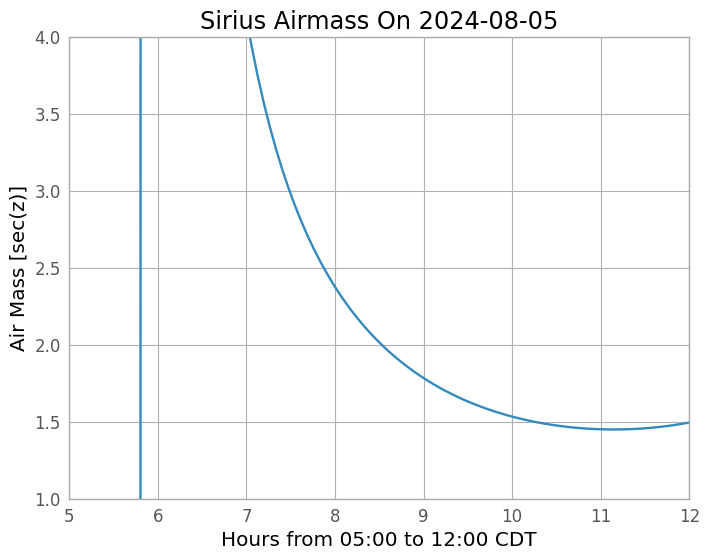

In [25]:
# plot Sirius airmass over given time range
plt.title(f'Sirius Airmass On {obs.date.str}')
plt.plot(time_range, sirius_airmass)
plt.xlabel(f'Hours from {tmin:02d}:00 to {tmax:02d}:00 {sirius.rise.local.tzname()}')
plt.xlim(tmin, tmax)
plt.ylabel('Air Mass [sec(z)]')
plt.ylim(1, 4)
plt.show()

## 4. Plot Sirius Alt & Az

In this section, we'll plot the altitude and azimuth of Sirius, along with the altitudes of the Sun and Moon, within the 12 hours before and after midnight on the given observation date. It also shows the duration of nighttime, bookended by twilight times.

In [26]:
# set observation time range in hours
tmin, tmax, tint = -12, 12, 1000
time_range = np.linspace(tmin, tmax, tint)*u.hour

In [27]:
# set observation times and hcs frame
obs_times = midnight+time_range
hcs_frame = AltAz(obstime=obs_times, location=obs.location)

In [28]:
# set Sun, Moon and Sirius positions in hcs frame
sun_pos = sun.transform_to(hcs_frame)
moon_pos = get_body('moon', obs_times).transform_to(hcs_frame)
sirius_pos = sirius.transform_to(hcs_frame)

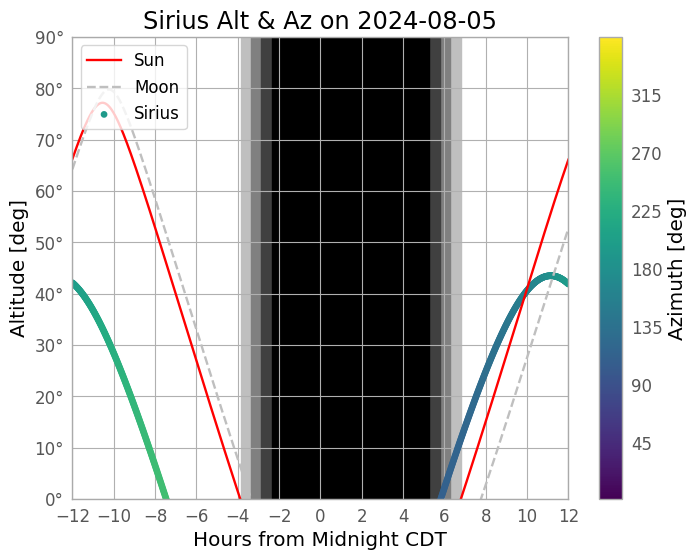

In [29]:
# plot Sirius alt & az with Sun and Moon alt for given time range

# set Sun, Moon and Sirius positions
plt.plot(time_range, sun_pos.alt, color='r', label='Sun')
plt.plot(time_range, moon_pos.alt,color=[0.75]*3, ls='--', label='Moon')
plt.scatter(time_range, sirius_pos.alt, c=sirius_pos.az.value, label='Sirius', lw=2, s=8, cmap='viridis')

# set civil/nautical/astro twilights and nighttime fills
plt.fill_between(time_range, 0*u.deg, 90*u.deg, sun_pos.alt < -0*u.deg, color='.75', zorder=0)
plt.fill_between(time_range, 0*u.deg, 90*u.deg, sun_pos.alt < -6*u.deg, color='.5', zorder=0)
plt.fill_between(time_range, 0*u.deg, 90*u.deg, sun_pos.alt < -12*u.deg, color='.25', zorder=0)
plt.fill_between(time_range, 0*u.deg, 90*u.deg, sun_pos.alt < -18*u.deg, color='k', zorder=0)

# plot figure
plt.title(f'Sirius Alt & Az on {obs.date.str}')
plt.colorbar(ticks=range(0,360,45)).set_label('Azimuth [deg]')
plt.legend(loc='upper left')
plt.xlabel(f'Hours from Midnight {sun.rise.local.tzname()}')
plt.xlim(tmin*u.hour, tmax*u.hour)
plt.xticks((np.arange(13)*2-tmax)*u.hour)
plt.ylabel('Altitude [deg]')
plt.ylim(0*u.deg, 90*u.deg)
plt.show()

## Conclusion

In conclusion, our goal was to dynamically model the heliacal rising of Sirius for a given place and date, so as to aid in finding a suitable observation window within the given constraints.

We calculated the rise times of the Sun, Twilights, and Sirius, then plotted the altitude and azimuth of Sirius in relation to the Sun and Moon over time. This, along with the airmass plot, gives a reasonable estimation of if or when the heliacal rise could be observed.

Perhaps in a future version, we could advance this study further and incorporate modeling the projected rising and setting times of Sirius over the course of a given year.

This study was inspired by the work of Erik Tollerud & Kelle Cruz in the Astropy Example Gallery linked below:
https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

**Author:** Aramis Delgado Morales  
**Date:** August 2024